In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# author:   Jan Hybs

import sys
import math
main = sys.modules['__main__']
import warnings
warnings.filterwarnings('ignore')


from tul.flow123d.experiments import Experiment as Exp
from tul.flow123d.data.base import D as Data
from tul.flow123d.data.base import Norm
from tul.flow123d.utils.stats import norm, drop_row, drop_col, drop_outliers, load_data
from tul.flow123d.data.preprocessing import ShiftDetection

from IPython.display import display, HTML
from pluck import pluck

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from   matplotlib.colors import LogNorm
import seaborn as sns

import pandas as pd
import scipy.optimize as op
import scipy.stats as st
import numpy as np


np.set_printoptions(precision=4, suppress=False)
np.random.seed(1234)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
def estimate_eq0(a,b,c,m):
    """ae^(c)+be^(m)"""
    return a * math.exp(c) + b * math.exp(m)

def estimate_eq1(a,b,c,m):
    """e^(a+c)+e^(b+m)"""
    return math.exp(a+c) + math.exp(b+m)

Data.test_drop   = [
     'mem_l1', 'mem_l2', 'mem_l3', 
     'cpu_simple', 'mmn_s4', 'mem_ll',
     'mvs_s1', 'mms_s1', 'mmn_s1',
     'cpu_hash', 'cpu_md5'
]
Data.mach_drop   = [
    'exmag',
    #'mudrc',
    #'ajax',
    'luna',
]
versions         =  '1.1.1', '1.1.2', '1.1.3', '1.1.4', '1.1.5'
version          = versions[0]
cut_count        = 15
repetition       = 25
normalize        = Norm.TEST_MACH
Data.estimate_eq = estimate_eq0
Data.penalty_mult= 1
Data.ftol        = 1e-7
Data.xtol        = Data.ftol

exp = Exp(
    (main, 'cut_count'),
    (main, 'version'),
    (main, 'repetition'),
    (main, 'normalize', Norm.find),
    (Data, 'estimate_eq', lambda x: x.__doc__),
    (Data, 'xtol'),
)

exp.data      = Data(load_data(version=version), normalize=normalize)
exp.baseline  = exp.data.estimate_abcm()
exp.estimates = dict()
display(exp)
display(exp.baseline.stats)

Experiment: 
    cut_count   = 15
    version     = 1.1.1
    repetition  = 25
    normalize   = TEST_MACH
    estimate_eq = ae^(c)+be^(m)
    xtol        = 1e-07

,min,mean,max,std
error,0.000075,0.016861,0.131782,0.026984


Experiment: 
    cut_count   = 15
    version     = 1.1.1
    repetition  = 25
    normalize   = TEST_MACH
    estimate_eq = ae^(c)+be^(m)
    xtol        = 1e-07

,min,mean,max,std
error,0.000075,0.016861,0.131782,0.026984


,alpha,beta
ref,1.981750e-08,4.313065e-08


,ajax,gram,hildor,mudrc,tarkil
alpha,3.323548e-08,1.703723e-08,1.558205e-08,1.650466e-08,1.672809e-08
beta,3.128035e-08,5.042361e-08,4.606732e-08,4.532781e-08,4.255415e-08


,mmn_s2,mmn_s3,mms_s2,mms_s3,mms_s4,mvs_s2,mvs_s3,mvs_s4
cpu,9.573483,10.557007,9.789112,9.807772,9.744426,9.624201,9.355630,9.369786
mem,10.046981,9.479142,10.091648,10.054028,10.056122,10.106245,10.114634,10.146303


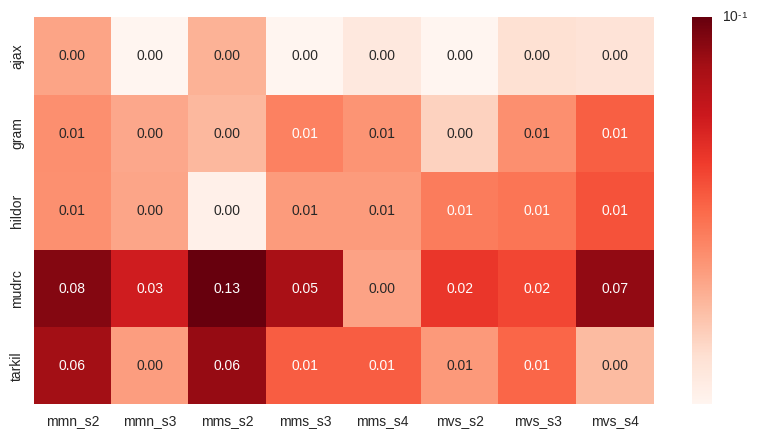

In [3]:
%matplotlib inline

display(exp)
display(exp.baseline.stats)
display(exp.baseline.ref_ab)
display(exp.baseline.ab)
display(exp.baseline.cm)
plt.figure(figsize=(10,5))
E = exp.baseline.rel_error
vmin, vmax = 1e-3, 1e-1
sns.heatmap(E, annot=True, fmt="1.2f", cmap='Reds', norm=LogNorm(vmax=vmax, vmin=vmin), vmax=vmax, vmin=vmin);


# estimate p and m value when \pi and \mu are known

import progressbar
def estimate_pm(version, repetition, test_data_size, prefix=''):    
    
    bar = progressbar.ProgressBar(
        fd=sys.stdout,
        term_width=80,
        widgets=[
            prefix,
            ' [', progressbar.Timer(), '] ',
            progressbar.Bar(marker='='),
            ' (', progressbar.ETA(), ') ',
        ]
    )
    
    exp.estimates[version] = list()
    bar.max_value = repetition
    with bar:
        for i in range(repetition):
            bar.update(i)

            d = Data(load_data(version=version), normalize=normalize)
            
            if test_data_size:
                d.cut_data(count=test_data_size)
            e = d.estimate_cm(exp.baseline.ab)

            exp.estimates[version].append(e)

def inspect_version(version):
    plt.figure(figsize=(15,10))
    p_values = np.vstack(pluck(exp.estimates[version], 'c'))
    m_values = np.vstack(pluck(exp.estimates[version], 'm'))

    for t in range(len(exp.baseline.test_list)):
        plt.subplot(3, 4, t+1)
        
        cpu_std = np.mean(p_values[:, t])
        mem_std = np.mean(p_values[:, t])
        plt.title('{:} $\sigma_p$={:1.3f}, $\sigma_m$={:1.3f} '.format(exp.baseline.test_list[t], cpu_std, mem_std))
        sns.distplot(p_values[:, t])
        sns.distplot(m_values[:, t])

def inspect_version_values(version):
    pass

In [4]:
# calculate estimations
for version in versions:
    estimate_pm(version, repetition*8, cut_count, version)

1.1.1 [Elapsed Time: 0:01:21] |===============================| (Time: 0:01:21) 


KeyboardInterrupt: 

In [5]:
%matplotlib inline


version = '1.1.1'
#estimate_pm(version, repetition*5, cut_count, version)
#inspect_version(version)
test = 'mms_s3'
c = np.vstack(pluck(exp.estimates[version], 'm'))
for v in versions:
    c = np.vstack((c, np.vstack(pluck(exp.estimates[v], 'm'))))

c = pd.DataFrame(c, columns=exp.baseline.test_list)
d = c[test].values
l = len(d)

shift_detect = ShiftDetection(h=30, k=30)
shifts = shift_detect.find_shift(d)

fig = plt.figure(figsize=(10, 5))
shift_detect.plot_find_result(shifts)
plt.tight_layout()

fig = plt.figure(figsize=(10, 2.5))
sns.regplot(np.arange(l), d, fit_reg=0)
plt.xlim(0, l)
plt.tight_layout()

KeyError: '1.1.2'

In [ ]:
n = Norm.NONE
d1 = Data(load_data('1.1.1'), normalize=n)
d2 = Data(load_data('1.1.2'), normalize=n)
for m in exp.baseline.mach_list:
    for t in exp.baseline.test_list:
        print(m, t, '{:1.2f}'.format(np.mean(d1[m, t]) - np.mean(d2[m, t])))